# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [5]:
# !pip install -U scikit-learn
# !pip install nltk


In [1]:
import os
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords




import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth',None)


In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка

In [3]:

path = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

toxic_df = pd.read_csv(path,index_col=0)


In [4]:
toxic_df.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [11]:
toxic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [12]:
#количество пропущенных значений
toxic_df.isna().sum()

,0
text,0
toxic,0


In [13]:
print('подсчёт явных дубликатов toxic_df:',toxic_df.duplicated().sum())

подсчёт явных дубликатов toxic_df: 0


<b>Вывод</b>

- Данные соответствуют по описанию задачи.
- Проверена наличие пропущенных значений явных дубликатов их нет.


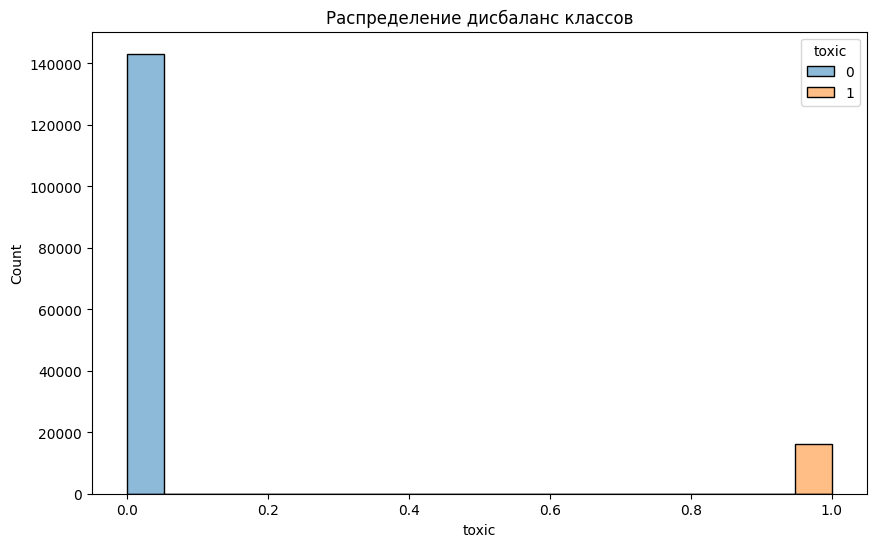

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=toxic_df, x='toxic',hue='toxic')
plt.title(f'Распределение дисбаланс классов')
plt.show()

<b>Вывод</b>

- Класс не дисбалансирован.

In [16]:
# Очищаем текст
def clear_text(text):
    text=text.lower()
    text = re.sub(r'(?:\n|\r)', ' ', text)
    t = re.sub(r'[^a-zA-Z ]', ' ', text)
    t=t.split()
    return ' '.join(t)

In [17]:
toxic_df['clear_text'] = toxic_df['text'].apply(clear_text)

In [18]:
toxic_df.head()

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


<b>Вывод</b>

- Очищали текст.

## Обучение

In [19]:
X=toxic_df['clear_text']
y=toxic_df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = TEST_SIZE,  random_state = RANDOM_STATE,stratify = y)

In [20]:
nltk.download('stopwords')
stopwords = list(set(nltk_stopwords.words('english')))
pipe_final = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [2,4,6],
        'models__max_features': [2,5,7]
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors':[1,5,10]
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5)}
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['once', "wasn't", 'couldn', 'then',
                                             'any', 'nor', 'other', 'our',
                                             "needn't", 'down', 'her', 'that',
                                             'shan', 'below', 'off', 'with',
                                             'do', 'you', 'be', 'only', 'won',
                                             'his', 'she', "mustn't", 'he',
                                             "you've", 'mightn', 'as', 'those',
                                             'ma', ...])),
                ('models',
                 LogisticRegression(C=3, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Метрика лучшей модели на тренировочной выборке: 0.7857404418688018


In [21]:
# Качество лучший модель на тестовой выборке
y_pred = randomized_search.predict(X_test)
print('Метрика f1_score:', f1_score(y_test, y_pred))

Метрика f1_score: 0.7816843826655765


In [22]:
# Параметры лучшего моделя
randomized_search.best_params_

{'models__C': 3,
 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}

<b>Вывод</b>

- Критерий успеха выполнено.
- Лучшая модел LogisticRegression с параметрами penalty='l1', random_state=42, solver='liblinear' и метрика на тесте f1_score=0.781.


## Выводы

- Разработали модель машинного обучения, которая классифицирует комментарии на позитивные и негативные.

- Провели предобработку данных: очищали текст.

- Для поиска лучшего моделя использовали пайплан с гиперпараметрами модели LogisticRegression(),DecisionTreeClassifier,KNeighborsClassifier() и поиска лучшего параметра RandomizedSearchCV.

- Лучшая модель LogisticRegression с параметрами penalty='l1', random_state=42, solver='liblinear' и метрика на тесте f1_score=0.781 .

- Рекомендую использовать для классификация комментарии  модель LogisticRegression с параметрами penalty='l1', random_state=42, solver='liblinear' .


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html

<font color='green'>Пример BERT с GPU:
```python
%%time
from tqdm import notebook
batch_size = 2 # для примера возьмем такой батч, где будет всего две строки датасета
embeddings = []
model.cuda()   # закидываем модель на GPU
for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
        batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
        del batch
        del attention_mask_batch
        del batch_embeddings

features = np.concatenate(embeddings)
```
Можно сделать предварительную проверку на наличие GPU.\
Например, так: ```device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")```\
Тогда вместо .cuda() нужно писать .to(device)

Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .


NLP от Samsung https://stepik.org/course/54098/promo \
NLP от Huawei https://ods.ai/tracks/nlp-course-autumn-2024 \
Transformers от Hugging Face https://huggingface.co/learn/nlp-course/ru/chapter1/1
</font>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны